# Tensor Component Analysis (TCA)

Running tensor component analysis (TCA) on pyAFQ diffusion kertosis imaging (DKI) tract profiles for corpus callosum bundles using probablistic constrained spherical deconvolition (CSD) from Human Connectome Project Young Adult 1200 Subject (HCP-YA) diffusion magnetic resonsance imaging (dMRI) data.

----
**Goals: Characterize Brain Microstructure Using Magnetic Resonance Imaging**

- Find patterns present in scalar factors that correlate to known histological properties in callosum. 

  - Use TCA factors to infer histological structure in other regions of white matter.
----

**TODO** 

- [ ] Correlate between histology, simulations, and TCA factors

  - For histology see
  
    <img src="Aboitiz 2003.png" width="50%"/>
    
    Aboitiz et al 1992. _Fiber composition of the human corpus callosum_
    
  - For simulations see 
  
    <img src="https://www.biorxiv.org/content/biorxiv/early/2021/03/22/2021.03.04.433972/F2.large.jpg?width=800&height=600&carousel=1" width="50%">
  
    Henriques et al. 2021 _Diffusional Kurtosis Imaging in the Diffusion Imaging in Python Project_
  
    https://www.biorxiv.org/content/10.1101/2021.03.04.433972v2.full
    
  - For DKI see
  
      Fieremans et al 2011. _White matter characterization with diffusion kertosis imaging_


- [ ] Finer grained segmentation (providing a gradient)

  split corpus collosum into 100 "bundles"
  
- [ ]  Create scikit TCA wrapper for pipelines

  - Incorporate TCA data transformers into AFQ-Insight using the scikit TCA implementation?

## Dataset

##### Dataset Information

Human Connectome Project Young Adult (HCP-YA)
- https://www.humanconnectome.org/study/hcp-young-adult

Using Human Connectome Project Young Adult (HCP-YA) 1200 Subject Release:
- https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release

    Release Reference Manual:
    - https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

In [77]:
def _get_subjects(bucket='hcp.callosum', dataset='test'):
    """
    infer the subject list from pyAFQ output directory structure in s3 `bucket`
    """
    import s3fs
    
    fs = s3fs.S3FileSystem()
    
    afq_path = 'afq'
    
    if dataset == 'retest':
        afq_path = 'afq_retest'
        
    return [f.split('sub-')[1] for f in fs.glob(f'{bucket}/derivatives/{afq_path}/sub-*')]

retrieve probabilistic tractography profiles from pyAFQ output stored in s3 `bucket`

In [3]:
def _download_and_combine_afq_profiles(bucket='hcp.callosum', dataset='test', save_csv=False):
    import s3fs
    import os
    from os.path import exists
    import pandas as pd

    fs = s3fs.S3FileSystem()

    dfs = []
    
    subjects = _get_subjects(bucket, dataset)
    
    afq_path = 'afq'
    
    if dataset == 'retest':
        afq_path = 'afq_retest'
        
    os.makedirs(f'{bucket}/{dataset}', exist_ok=True)
    
    for subject in subjects:
        # NOTE assuming one session
        fname = f'sub-{subject}_dwi_space-RASMM_model-CSD_desc-prob-afq_profiles.csv'
        local_fname = f'{bucket}/{dataset}/{fname}'
        
        if not exists(local_fname):
            if fs.ls(f'{bucket}/derivatives/{afq_path}/sub-{subject}/ses-01/{fname}'):
                fs.get(
                    f'{bucket}/derivatives/{afq_path}/sub-{subject}/ses-01/{fname}',
                    local_fname
                )
        
        if exists(local_fname):
            profiles = pd.read_csv(local_fname, index_col=[0])
            profiles.insert(0, 'subjectID', subject)
        
            dfs.append(profiles)
        
    combined_df = pd.concat(dfs)
    combined_df.reset_index(inplace=True, drop=True)
    
    if save_csv:
        combined_df.to_csv("tract_profiles.csv", index=False)

    return combined_df

#### Dataframe

`df` is pandas `Dataframe` with columns for:
- subject (`subjectID`),
- bundle (`tractID`),
- scalars,
  - `dki_fa` - fractional anistrophy,
  - `dki_md` - mean diffusivity
  - `dki_mk` - mean kertosis
  - and `dki_awf` - axonal water fraction
- and nodes (`nodeID`)

##### test-retest dataset

Subset of the HCP-YA dataset including only subjects with two sessions (test and retest scans). The pyAFQ tract profiles for these subjects in this bucket was processed for only callosal bundles (thus no reason to filter dataframe)

However remaining tract profiles for other bundles are available if desired for additional analysis in other buckets (**warning** these were not processed at same time so some variances may exist)

##### full dataset (**callosal bundles only**)

remove any non-callosal bundles

In [4]:
df = _download_and_combine_afq_profiles(bucket='hcp.afq', save_csv=False)

# filter the available tracts to only those in callosum
df = df[df.tractID.isin(['AntFrontal', 'Motor', 'Occipital', 'Orbital',
       'PostParietal', 'SupFrontal', 'SupParietal', 'Temporal'])]
df.reset_index(inplace=True, drop=True)

##### variables for tensor dimensions

In [5]:
_subjects = df.subjectID.unique()
_tracts = df.tractID.unique()
_nodes = df.nodeID.unique()
_scalars = ['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']

##### order tracts anatomically

Group spatially anterior to posterior, to help with visualization and interpretation.

In [9]:
def get_anat_tracts():
    import numpy as np
    return np.array(["Orbital", "AntFrontal", "SupFrontal", "Motor", "SupParietal", "PostParietal", "Temporal", "Occipital"], dtype=object)

_anat_tracts = get_anat_tracts()
_anat_tracts

array(['Orbital', 'AntFrontal', 'SupFrontal', 'Motor', 'SupParietal',
       'PostParietal', 'Temporal', 'Occipital'], dtype=object)

##### normalize scalars

- Want to check effects of normalization on resulting tensor decomposition

    since metrics are different scales, this using unnormalized scalars could lead to under weighting the variance, specifically in in mean diffustivity (MD)

    see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [10]:
def normalize_df(df, with_mean=True):
    """
    Biased normalization using sklearn
    """
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler(with_mean=with_mean)
    
    df_normalized = df.copy()
    df_normalized[_scalars] = scaler.fit_transform(df_normalized[_scalars].to_numpy())
    return df_normalized

In [419]:
df_normalized = normalize_df(df)

##### visualize dataframe

`_summary_stats` function

  anatomically ordered bundles for each scalar value

95% confidence interval tract profile for each bundle and scalar across all subjects

cross subject variance

- [x] confirm seaborn is doing 95 CI

> By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.

https://seaborn.pydata.org/generated/seaborn.lineplot.html

In [452]:
def _summary_stats(df, fig=None, axs=None, show=True, linestyle='solid'):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    if fig is None:
        colors = sns.color_palette()
    else:
        colors = sns.color_palette(desat=.2)

    # order bundles front to back
#     display(df)
    df1 = df.copy()
#     display(df1)
    df1['tractID'] = pd.Categorical(
        df1['tractID'], 
        categories=["Orbital", "AntFrontal", "SupFrontal", "Motor", "SupParietal", "PostParietal", "Temporal", "Occipital"],
        ordered=True
    )
#     display(df1)
    
    df_grouped = df1.groupby('tractID')
    
    if fig is None:
        fig, axs = plt.subplots(nrows=len(_scalars), ncols=len(_tracts), sharex=True, sharey='row', figsize=(16,8))
        
    axs_r = axs.ravel()
    
    for row_id, (bundle_name, group) in enumerate(df_grouped):
#         print(row_id, bundle_name)
#         display(group)
        axs_r[row_id].set_title(bundle_name)
        for scalar in _scalars:
            sns.lineplot(
                ax=axs_r[_scalars.index(scalar)*len(df_grouped)+row_id], 
                data=group[scalar].rename(lambda x: x % len(_nodes)),
                linestyle=linestyle,
                color=colors[_scalars.index(scalar)]
            )

    if show:
        plt.show()
    
    return fig, axs

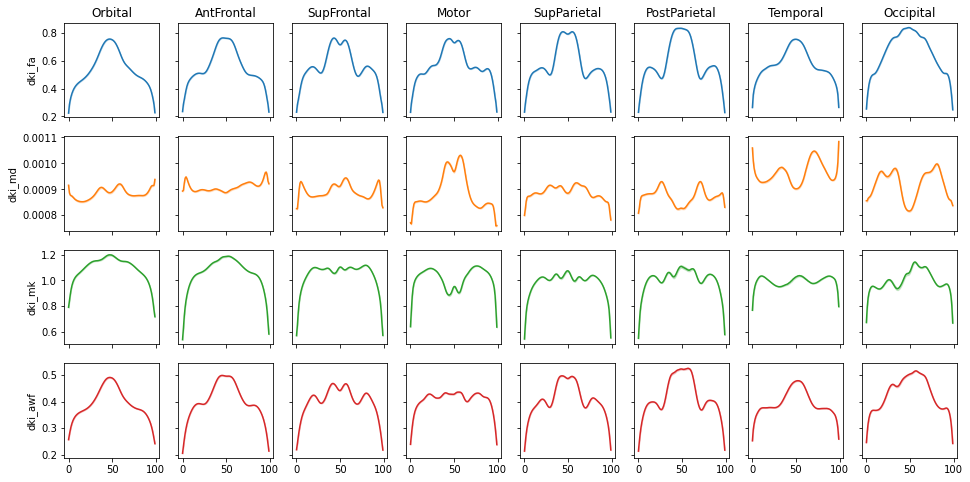

In [454]:
_ = _summary_stats(df)

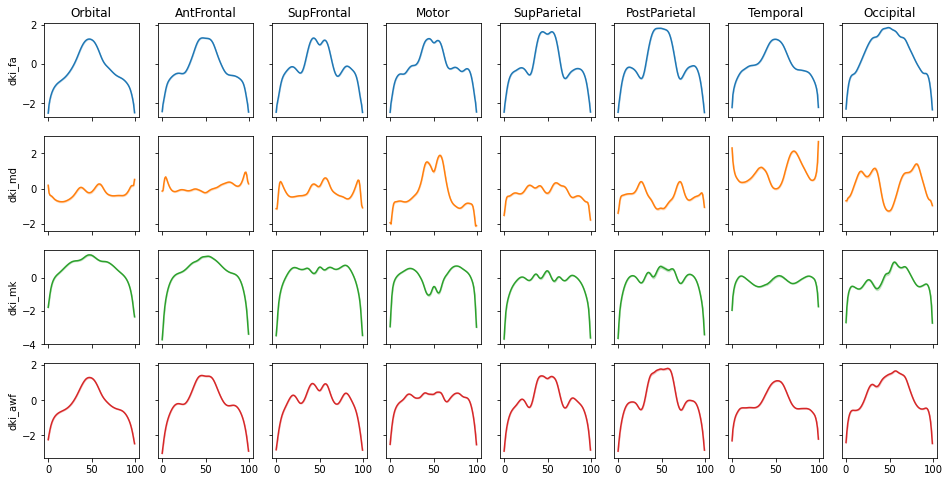

In [455]:
_ = _summary_stats(df_normalized)

**NOTE: scalars create distintive bundle signitures, patterns within scalars as move anterior to posterior**

## Tensor

Constuct a `S` x `B` x `M` x `N` tensor from the dataframe. 

Where
- `S` is number of subjects
- `B` is number of bundles
- `M` is number of metrics/scalars
- `N` is number of nodes

In [79]:
def get_anatomical_data_tensor(df, scalars = _scalars):
    """order bundles anatomically"""
    import pandas as pd
    
    # order bundles front to back
    df1 = df.copy()
    df1['tractID'] = pd.Categorical(
        df1['tractID'], 
        categories=["Orbital", "AntFrontal", "SupFrontal", "Motor", "SupParietal", "PostParietal", "Temporal", "Occipital"],
        ordered=True
    )
#     display(df1.head())
    df2 = df1.sort_values(['subjectID', 'tractID', 'nodeID']).reset_index(drop=True)
#     display(df2.head())
    df3 = df2.groupby(['subjectID', 'tractID', 'nodeID'])[scalars].apply(pd.DataFrame)
#     display(df3.head())
    data = df3.values.reshape(len(_subjects), len(_tracts), len(_nodes), len(scalars))
    return data.transpose(0,1,3,2)

`get_dataframe_from_tensor` function

given a tensor "reconstruct" the dataframe -- inverse operation

In [34]:
def get_dataframe_from_tensor(tensor):
    import pandas as pd
    import numpy as np

    df = pd.DataFrame(tensor.transpose(2,0,1,3).reshape([len(_scalars), len(_subjects)*len(_anat_tracts)*len(_nodes)]).T)
    df.columns = _scalars
    df['nodeID'] = list(_nodes)*(len(_subjects)*len(_anat_tracts))
    df['tractID'] = list(np.repeat(_anat_tracts, len(_nodes)))*len(_subjects)
    df['subjectID'] = list(np.repeat(_subjects, len(_anat_tracts)*len(_nodes)))
        
    return df

In [81]:
normalized_anat_data = get_anatomical_data_tensor(df_normalized)
normalized_anat_data.shape

(1041, 8, 4, 100)

##### sanity check 

recapitulate the original data summmary statistics from tensor

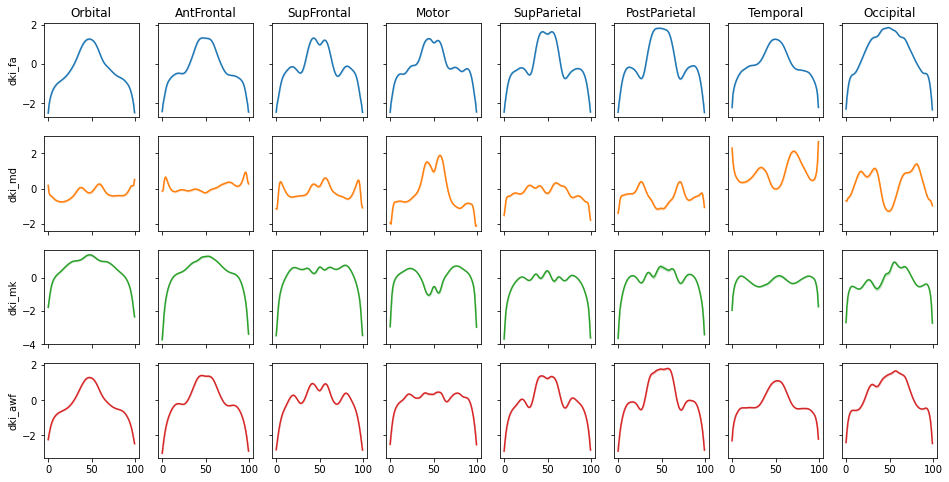

In [457]:
_ = _summary_stats(get_dataframe_from_tensor(normalized_anat_data))

**NOTE: visually very good reconstruction**

**TODO**

- [ ] quantify numerically

## TCA Model

`tca` function

**NOTE** CP: Canonical decomposition (**C**ANDECOMP)/parallel factors (**P**ARFAC)

- choosing **fit method**, so can run cross validation

  - `cp_als` CP decomposition using alternative least squares (ALS) -- **good first algorithm to try**
  - `ncp_hals` **nonnegative** CP decomposition by hierarchical alternating least squares (HALS)
  - `ncp_bcd` nonnegative CP Decomposition using the block coordinate descent (BCD)
  - `mcp_als` CP Decomposition with **missing data** using Alternating Least Squares (ALS) -- **exploited to perform cross-validation**
  
- chose **number of components** based on trial-and-error (i.e. larger components did not significantly contribute)
- chose **number of replicates** based on default, could add more for better estimation

**Considerations**

Data properties dictate certain constraints on TCA
- [x] sparsity - (tensor is not sparse)
- [x] normalized values (MD is not similar scale)
- [x] nonnegative / postitivity constraint (all scalars are positive, may be TCA factors should be similarly nonnegatively constrained) -- see `ncp_hals` and `ncp_bcd` `fit_method`s

**TODO** 

- [ ] Develop nonnegative CP decomposition with missing data using Alternating Least Squares (ALS) `fit_method`: `mncp_hals` for cross-validation.

  - **NOTE** `Ensemble` takes a `nonneg` bool where if `True`, constrains low-rank factor matrices to be nonnegative.
  
    - [ ] try fit ensemble with `nonneg=True`

Try various:
- [x] fit methods (ncp_hals, mcp_als, ...)
- [x] number of components (1-9 ... 30)
- [ ] number of replications (4)

In [25]:
def tca(data, fit_method = "ncp_hals", max_r = 9, n_replicates = 4):
    import tensortools as tt
    ensemble = tt.Ensemble(fit_method=fit_method)
    ensemble.fit(data, ranks=range(1, max_r), replicates=n_replicates, verbose=False)
    return ensemble

`plot_analysis` function
- plot the objective function, evaluated using replicates, looking for minimal average value
- plot the model similiarity, want replicate factors to be as similar as possible

In [26]:
def plot_analysis(ensemble):
    import matplotlib.pyplot as plt
    import tensortools as tt
    
    fig, axes = plt.subplots(1, 2)
    tt.plot_objective(ensemble, ax=axes[0]) 
    tt.plot_similarity(ensemble, ax=axes[1])
    fig.tight_layout()

`plot_factors` function

- visualize each of the factors, to inspect for patterns

In [27]:
def plot_factors(ensemble, num_components = 8, replicate = 0):
    import matplotlib.pyplot as plt
    import tensortools as tt
    
    fig, axes, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate])
    for ax in axes.flat:
        ax.axhline(y=0, c="red", ls="--")
        
    for ax in axes[:,1]:
        ax.set_xticks(list(range(len(_tracts))))
#         ax.set_xticklabels(_tracts, rotation = 90, ha='center')
        ax.set_xticklabels(_anat_tracts, rotation = 90, ha='center')
        
    for ax in axes[:,2]:
        ax.set_xticks(list(range(len(_scalars))))
        ax.set_xticklabels(_scalars, rotation = 90, ha='center')

    plt.show()

### Subject x Bundle x Scalar (mean)

sanity check - what happens when use mean instead of all nodes?

normalized

### Subject x Bundle x Scalar x Node

Full tensor

Normalized tensor

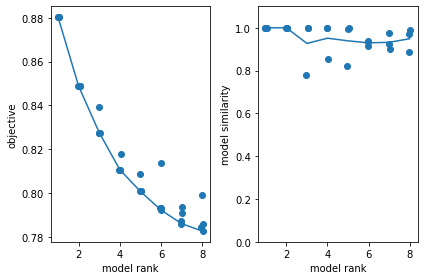

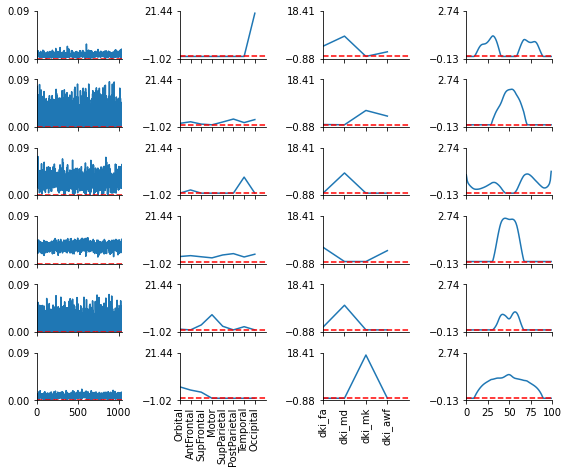

In [38]:
normalized_full_ensemble = tca(normalized_anat_data)
plot_analysis(normalized_full_ensemble)
plot_factors(normalized_full_ensemble, num_components=6)

**NOTE:** non-negative values

Compare to masked cross validation results

## Masked Cross Validation

Assess relative train-test performance on 10% masked cross-validation on full data for rank 1 through rank 30 factorization.

_Running a large number of cross validated factors is computationally slow._

**NOTE This is the model used analysis, visualization, and behavoiral predictions in remainder of notebook**

**TODO**

Explore effects of:

- [ ] number of replicates

- [ ] mask percentages

In [83]:
def masked_als(data, max_r=9, n_replicates=4, mask_pct=.1):
    import numpy as np
    import tensortools as tt
    import functools
    
    mask = np.random.rand(*data.shape) > mask_pct
    mcp_als = functools.partial(tt.mcp_als, mask=mask, verbose=False)
    ensemble = tca(data, fit_method=mcp_als, max_r=max_r)
    
    return ensemble, mask

In [239]:
normalized_masked_ensemble, normalized_mask = masked_als(normalized_anat_data, max_r=30)

In [325]:
def vis_masked(data, ensemble, mask, max_r=9, n_replicates=4, num_components=None, all_ranks=False, all_replicates=False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plot_analysis(ensemble)
    plt.show()

    error = {}
    
    for replicate in range(0, n_replicates):
        error[replicate] = {'train': [], 'test': []}
        
        if not all_replicates:
            break

    if not all_ranks:
        if num_components is None:
            rand_r = np.random.choice(range(1, max_r), 1)
        else:
            rand_r = num_components
        
    for r in range(1, max_r):
        for replicate in range(0, n_replicates):
            if all_ranks or r == rand_r:
                print(f'number of components: {r}, replicate: {replicate}')
                plot_factors(ensemble, num_components=r, replicate=replicate)

            data_hat = ensemble.factors(r)[replicate].full()
            
            error[replicate]['train'].append(np.linalg.norm(data_hat[mask] - data[mask]) / np.linalg.norm(data[mask]))
            error[replicate]['test'].append(np.linalg.norm(data_hat[~mask] - data[~mask]) / np.linalg.norm(data[~mask]))

            if not all_replicates:
                break


    df = pd.DataFrame({(replicate,trial): error[replicate][trial] 
                            for replicate in error.keys() 
                            for trial in error[replicate].keys()})

    for replicate in range(0, n_replicates):
        df[replicate].plot()
        plt.show()
        
        if not all_replicates:
            break

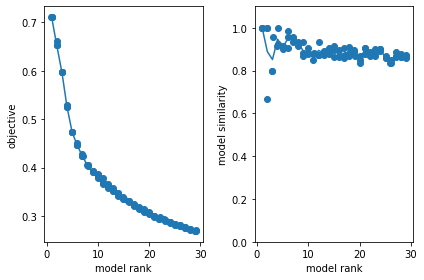

number of components: 6, replicate: 0


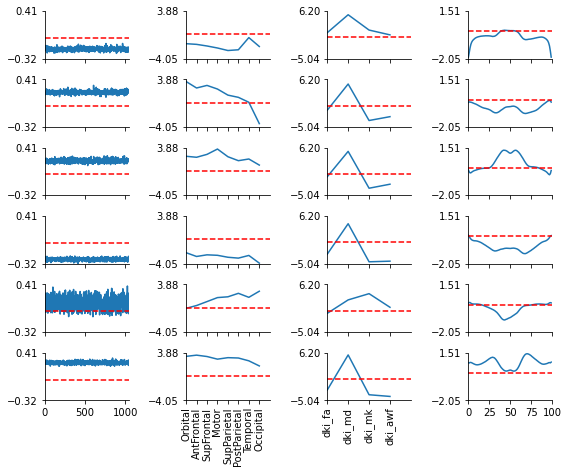

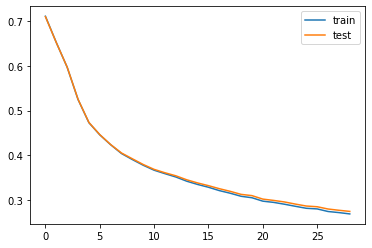

In [327]:
vis_masked(normalized_anat_data, normalized_masked_ensemble, normalized_mask, max_r=30, num_components=6)

#### Save ensemble

Save artifacts from masked cross-validation

In [276]:
def save(data, mask, ensemble, prefix='callosum'):
    import pickle as pkl
    import numpy as np

    np.save(f'{prefix}_subjects.npy', _subjects)
    np.save(f'{prefix}_data.npy', data)
    np.save(f'{prefix}_mask.npy', mask)
    pkl.dump(ensemble, file = open(f'{prefix}_ensemble.pkl', 'wb'))

In [277]:
save(normalized_anat_data, normalized_mask, normalized_masked_ensemble)

## Analysis

##### Identify significant difference in signatures between/amongst TCA factors

Are factors correlated? Using `p_values` function

 - Compare factors within replicate given number of components
 - Compare factors across replicates for given number of components
 - Compare factors across components
 
##### Concerns with using p-value
 - Are there sufficent numbers of samples to have confidence in p-values
 - Is stacking the factors valid? Since some factors are larger than others not weighted equivallently
 - Would ANOVA be more appropriate?

## Visualizations

- PCA Projection of TCA factors
- 2D TCA factor products
- TCA component projections
- High and Low TCA subject factors

### PCA projection of TCA factors

These factors have `n_components` use PCA to visualize in 2D space.

Idea from
- Kolda, Viz of Experiment Factor Matrix Using PCA Projection, _Tensor Decomposition: A Mathematical Tool for Data Analysis_

  https://youtu.be/L8uT6hgMt00?t=1698
  
  https://www.osti.gov/servlets/purl/1513637

Q: Are there any groups or clusters present in the projections?

**TODO**

- [ ] Run PCA on factor products

In [44]:
def viz_factor(ensemble, n_components=8, replicate=0):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    
    print('subject matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[0].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], legend=False)
#     sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=df.subjectID.unique())
#     plt.legend(bbox_to_anchor=(1.05, 1), ncol=4)
    plt.show()

    
    print('bundle matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[1].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=_anat_tracts)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
    
    print('scalar matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[2].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=_scalars)
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()
    
    print('node matrix PCA projection')
    pca.fit(ensemble.factors(n_components)[replicate].factors[3].T)
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue=_nodes)
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.show()

subject matrix PCA projection


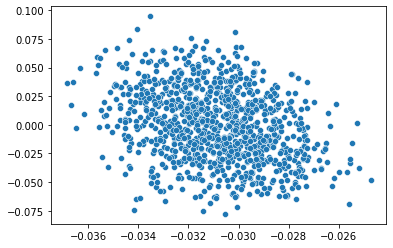

bundle matrix PCA projection


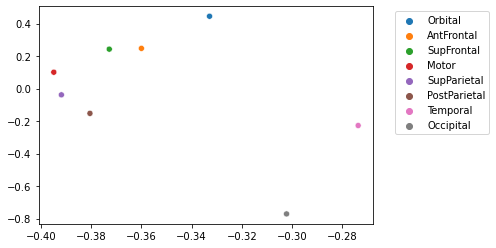

scalar matrix PCA projection


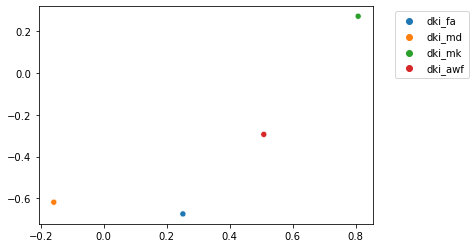

node matrix PCA projection


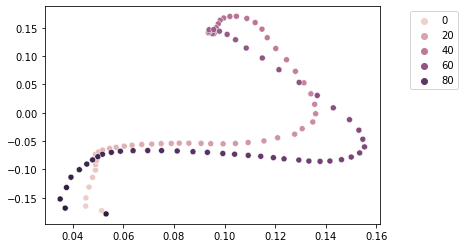

In [243]:
viz_factor(normalized_masked_ensemble, n_components=6)

**NOTE: bundle projection: anterior to posterior represented captured on the vertical component**

#### Visualize factor products

Gray-scale image weights of all 2-factor products

Idea from:
- Tensor Factorization for Graph Analysis in Python   

  https://medium.com/yadb/tensor-factorization-for-graph-analysis-in-python-590df44c9f6c
  
  subgraph of the original graph describing the sub connections

In [46]:
def viz_factor_product(ensemble, n_components=8, replicate=0):
    import numpy as np
    import matplotlib.pyplot as plt
    
    
    print('subject by bundle')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[1].T), aspect='auto', cmap='Greys', interpolation='none')
#     plt.xticks(range(len(_tracts)), _tracts)
    plt.xticks(range(len(_anat_tracts)), _anat_tracts)
#     plt.yticks(range(len(_subjects)), _subjects)
    plt.ylabel("subject index")
    plt.xlabel("bundle name")
    plt.colorbar()
    plt.show()
    
    print('subject by scalar')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[2].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.xticks(range(len(_scalars)), _scalars)
#     plt.yticks(range(len(_subjects)), _subjects)
    plt.ylabel("subject index")
    plt.xlabel("scalar name")
    plt.colorbar()
    plt.show()
    
    print('subject by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[0],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
#     plt.yticks(range(len(_subjects)), _subjects)
    plt.ylabel("subject index")
    plt.xlabel("node index")
    plt.colorbar()
    plt.show()
    
    print('bundle by scalar')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[1],ensemble.factors(n_components)[replicate].factors[2].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.xticks(range(len(_scalars)), _scalars)
    plt.yticks(range(len(_anat_tracts)), _anat_tracts)
    plt.ylabel("bundle name")
    plt.xlabel("scalar name")
    plt.colorbar()
    plt.show()
    
    print('bundle by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[1],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.yticks(range(len(_anat_tracts)), _anat_tracts)
    plt.ylabel("bundle name")
    plt.xlabel("node index")
    plt.colorbar()
    plt.show()
    
    print('scalar by node')
    plt.imshow(np.dot(ensemble.factors(n_components)[replicate].factors[2],ensemble.factors(n_components)[replicate].factors[3].T), aspect='auto', cmap='Greys', interpolation='none')
    plt.yticks(range(len(_scalars)), _scalars)
    plt.ylabel("scalar name")
    plt.xlabel("node index")
    plt.colorbar()

subject by bundle


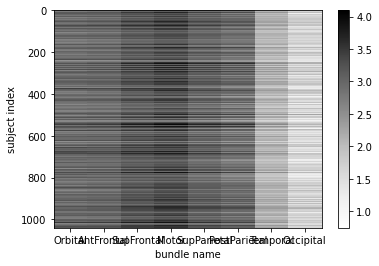

subject by scalar


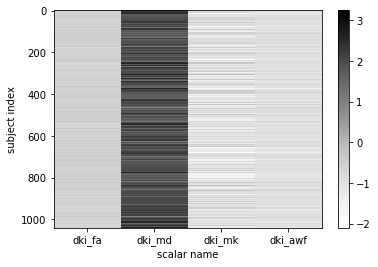

subject by node


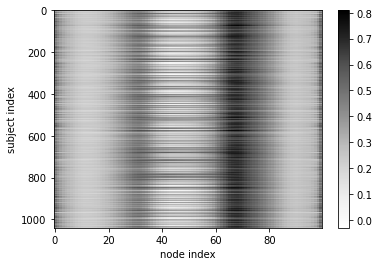

bundle by scalar


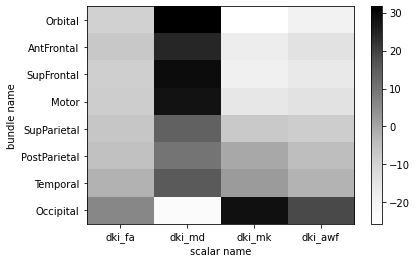

bundle by node


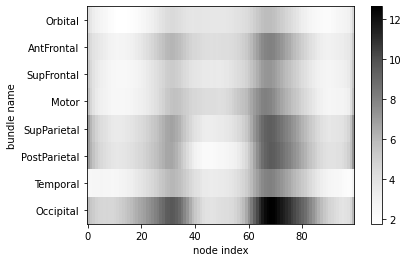

scalar by node


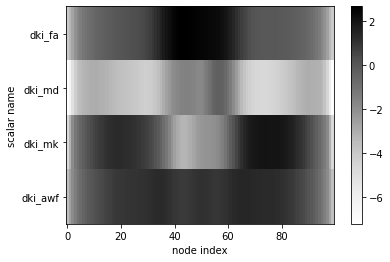

In [244]:
viz_factor_product(normalized_masked_ensemble, n_components=6)

### sanity check 

recapitulate data from the TCA factors (this should be an estimate)

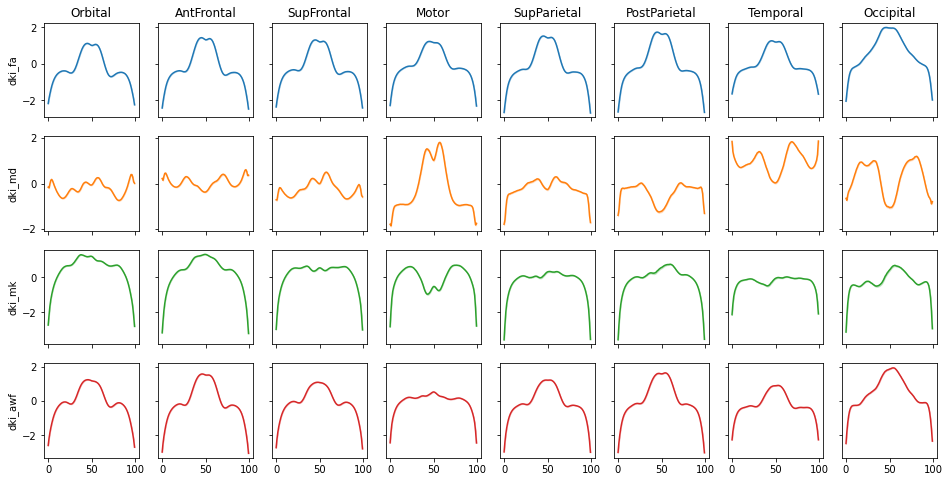

In [458]:
_ = _summary_stats(get_dataframe_from_tensor(normalized_masked_ensemble.factors(6)[0].full()))

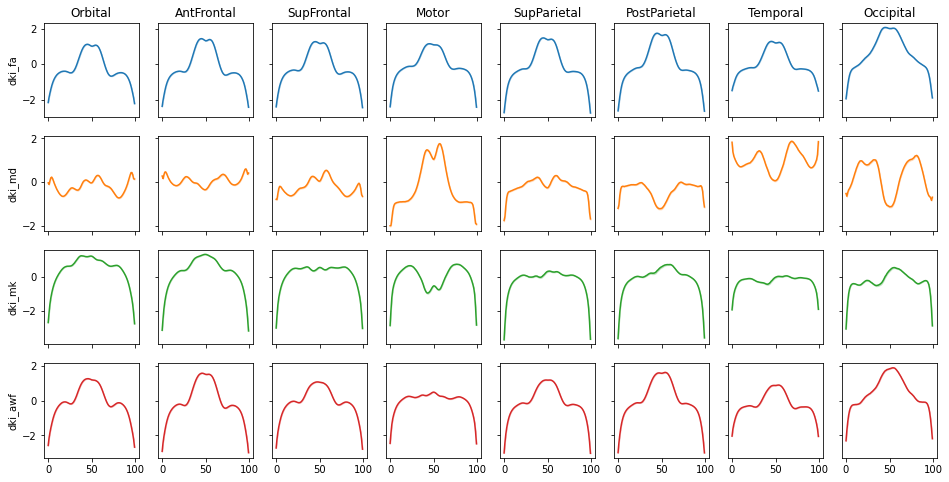

In [459]:
_ = _summary_stats(get_dataframe_from_tensor(normalized_masked_ensemble.factors(6)[1].full()))

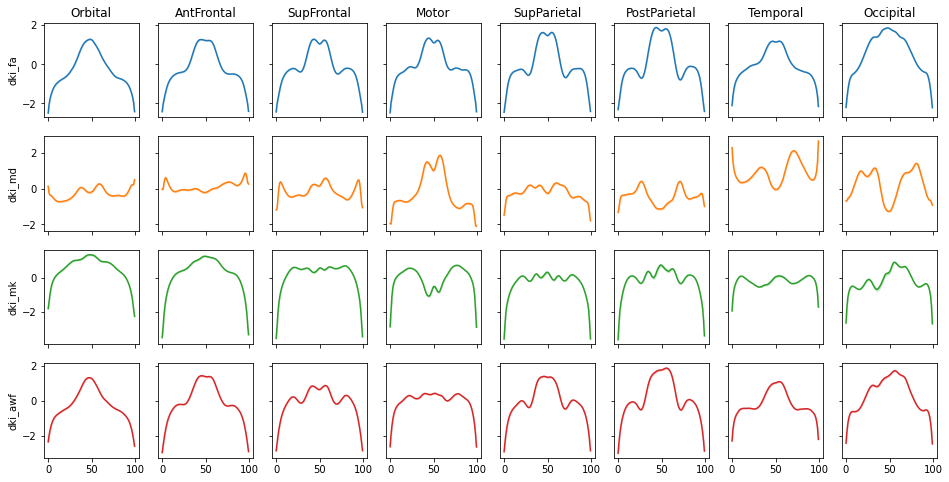

In [460]:
_ = _summary_stats(get_dataframe_from_tensor(normalized_masked_ensemble.factors(29)[0].full()))

**NOTE: as expected more factors is better estimate for original**

#### Project Factors

Reproject factor into summary stats, this gives an indiciation of what each factor captures

In [48]:
def project(ensemble, n_components=8, replicate=0):
    from tensortools.operations import khatri_rao
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    colors = sns.color_palette()
    
    ktensor = ensemble.factors(n_components)[replicate]
    
    for i in range(n_components):
        factor_tensor = khatri_rao(ktensor.factors)[:,i].reshape(ktensor.shape)
        _summary_stats(get_dataframe_from_tensor(factor_tensor))

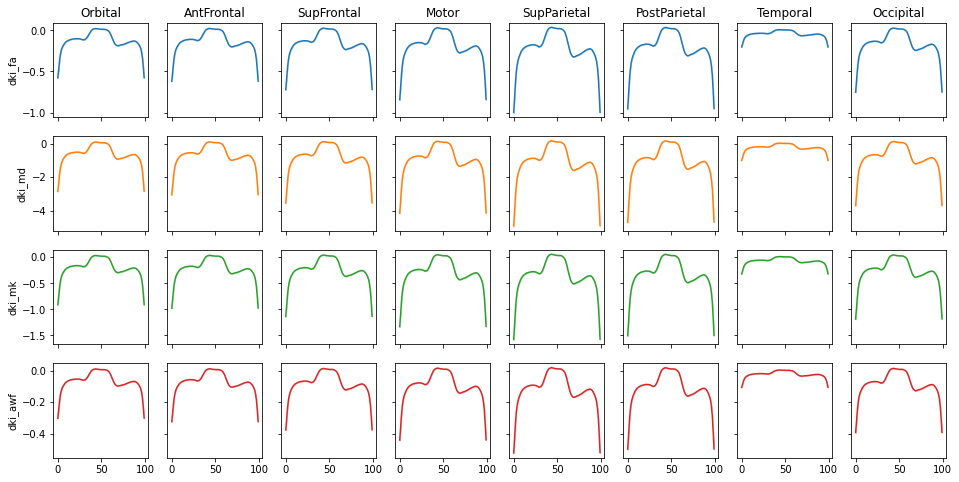

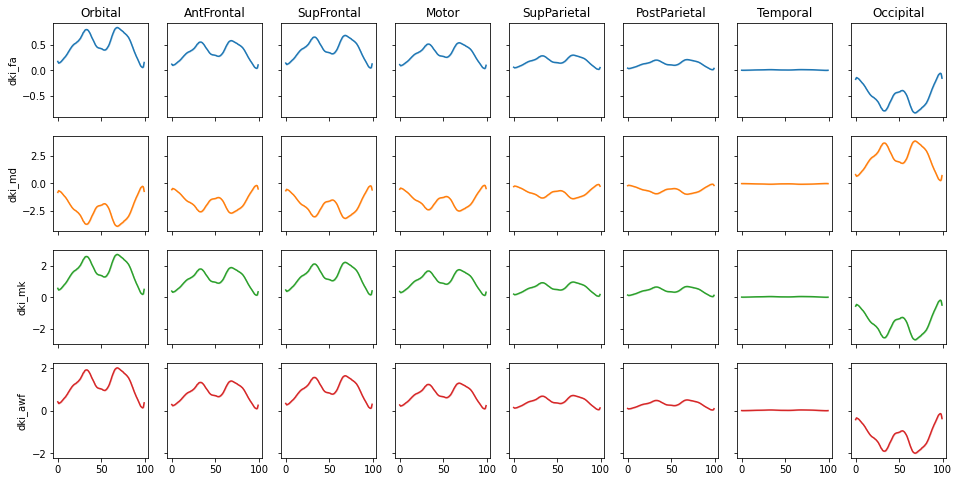

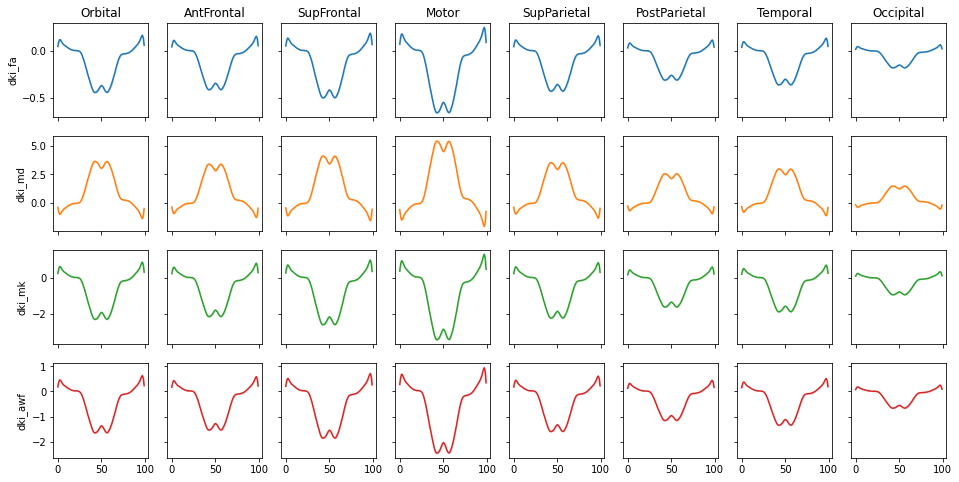

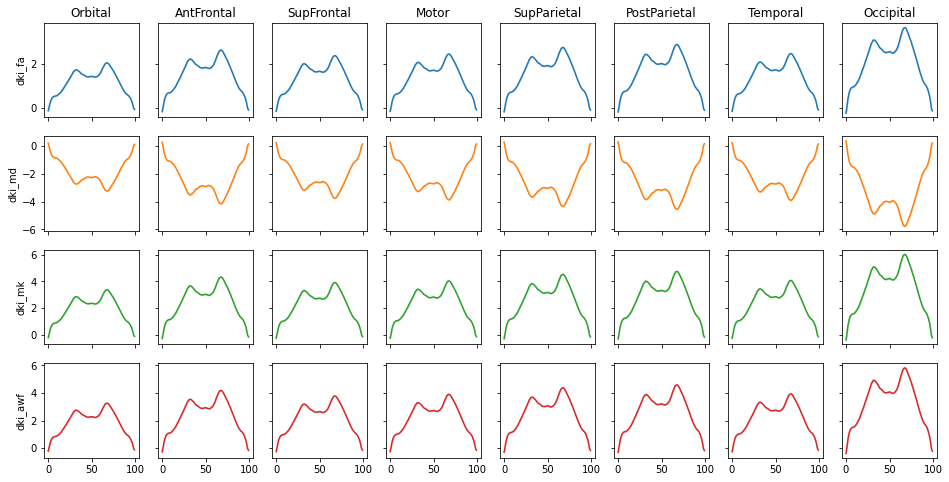

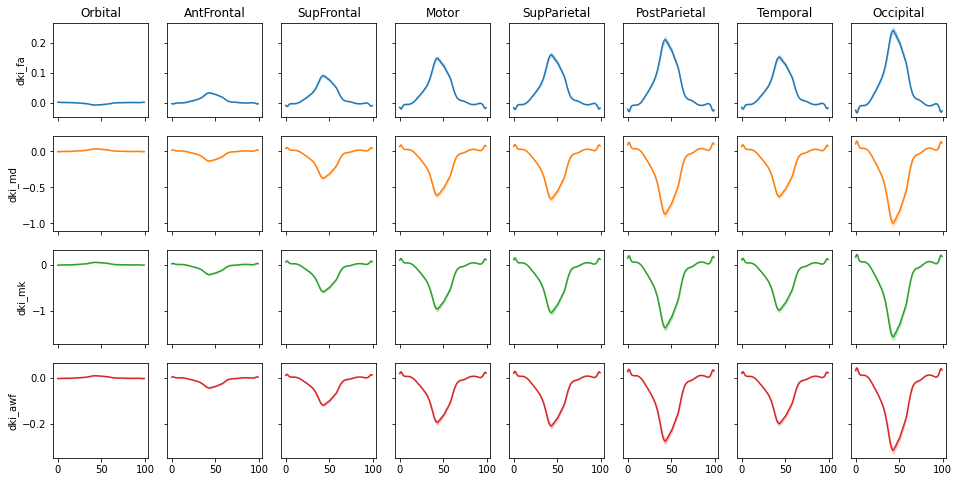

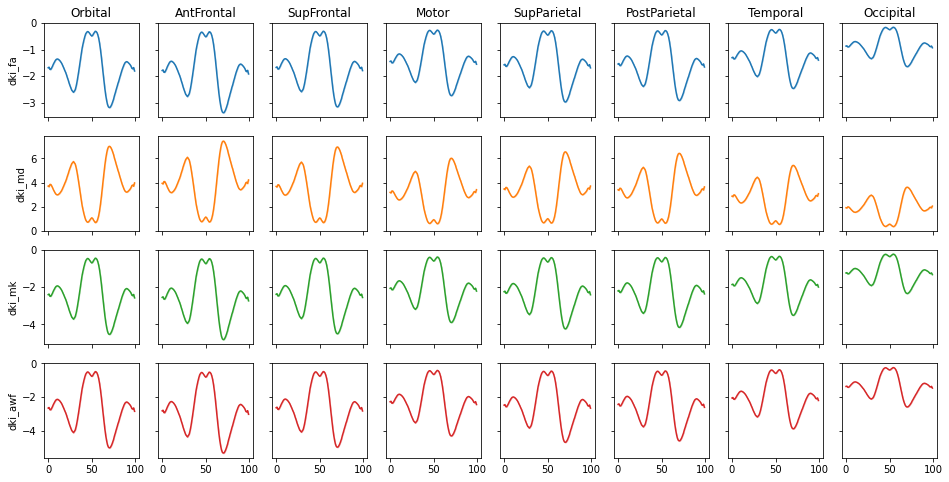

In [355]:
project(normalized_masked_ensemble, n_components=6)

#### high-low subject factors

Using factors to make predictions -- what do these high and low factors capture?

- [x] projection of a population of `n_subjects` with high and low subject factor scores

  - [x] plot both populations in same visualization


- [ ] consider using factor products

In [432]:
def sample_high_low(ensemble, n_components=8, replicate=0, n_subjects=2):
    """ find subjects with highest and lowest subject factors and plot summary_stats """
    import numpy as np
    import pandas as pd
    from matplotlib import lines
    import matplotlib.pyplot as plt
    from tensortools.operations import khatri_rao
    
    print(f'{n_subjects} subjects from {replicate} replicate {n_components} rank tensor')
    
    ktensor = ensemble.factors(n_components)[replicate]

    subject_factor = ktensor.factors[0] # (n_subjects, n_components)
    
    subject_factor_sum = subject_factor.sum(axis=1)
    # display subject factor score distribution
#     pd.DataFrame(subject_factor_sum).sort_values(by=0).plot.bar()
#     plt.gca().xaxis.set_visible(False)
#     plt.show()

    max_indicies = np.argpartition(subject_factor_sum, -n_subjects)[-n_subjects:]   
    min_indicies = np.argpartition(subject_factor_sum, n_subjects)[:n_subjects]
    
    # plot mean sum for each factor for each group
    frames = [
        pd.DataFrame(subject_factor[max_indicies], index=_subjects[max_indicies]),
        pd.DataFrame(subject_factor[min_indicies], index=_subjects[min_indicies])
    ]
    
    pd.concat(frames, keys=["high", "low"]).groupby(level=0).mean().T.plot.bar(legend=(n_subjects < 10))
    plt.legend(['high subjects', 'low subjects'])
    plt.axhline(y=0, c="black")
    plt.title('average subject factors')
    plt.gca().set_ylabel(r'$\alpha$')
    plt.gca().set_xlabel('component')
    plt.show()
    
    # original
    fig, axs = _summary_stats(df_normalized[df_normalized['subjectID'].isin(_subjects[max_indicies])], show=False)
    fig, axs = _summary_stats(df_normalized[df_normalized['subjectID'].isin(_subjects[min_indicies])], fig, axs, show=False, linestyle='dashed')
    fig.legend([lines.Line2D([0], [0], ls='-', c='k'), lines.Line2D([0], [0], ls='--', c='k')], ['high subjects', 'low subjects'])
    fig.suptitle('original raw tract profiles')
    plt.show()
    
    # projected                          
    max_tensor = ktensor.full()[max_indicies]
    max_df = pd.DataFrame(max_tensor.transpose(2,0,1,3).reshape([len(_scalars), len(max_indicies)*len(_anat_tracts)*len(_nodes)]).T)
    max_df.columns = _scalars
    max_df['nodeID'] = list(_nodes)*(len(max_indicies)*len(_anat_tracts))
    max_df['tractID'] = list(np.repeat(_anat_tracts, len(_nodes)))*len(max_indicies)
    max_df['subjectID'] = list(np.repeat(_subjects[max_indicies], len(_anat_tracts)*len(_nodes)))
    
    fig, axs = _summary_stats(max_df, show=False)

    min_tensor = ktensor.full()[min_indicies]
    min_df = pd.DataFrame(min_tensor.transpose(2,0,1,3).reshape([len(_scalars), len(min_indicies)*len(_anat_tracts)*len(_nodes)]).T)
    min_df.columns = _scalars
    min_df['nodeID'] = list(_nodes)*(len(min_indicies)*len(_anat_tracts))
    min_df['tractID'] = list(np.repeat(_anat_tracts, len(_nodes)))*len(min_indicies)
    min_df['subjectID'] = list(np.repeat(_subjects[min_indicies], len(_anat_tracts)*len(_nodes)))
    
    fig, axs = _summary_stats(min_df, fig, axs, show=False, linestyle='dashed')
    
    fig.legend([lines.Line2D([0], [0], ls='-', c='k'), lines.Line2D([0], [0], ls='--', c='k')], ['high subjects', 'low subjects'])
    fig.suptitle('projected tract profiles')
    plt.show()
  
    # individual factor
    factor = 4
    factor_tensor = khatri_rao(ktensor.factors)[:,factor].reshape(ktensor.shape)
    
    max_factor_tensor = factor_tensor[max_indicies]
    max_factor_df = pd.DataFrame(max_factor_tensor.transpose(2,0,1,3).reshape([len(_scalars), len(max_indicies)*len(_anat_tracts)*len(_nodes)]).T)
    max_factor_df.columns = _scalars
    max_factor_df['nodeID'] = list(_nodes)*(len(max_indicies)*len(_anat_tracts))
    max_factor_df['tractID'] = list(np.repeat(_anat_tracts, len(_nodes)))*len(max_indicies)
    max_factor_df['subjectID'] = list(np.repeat(_subjects[max_indicies], len(_anat_tracts)*len(_nodes)))
    
    fig, axs = _summary_stats(max_factor_df, show=False)
    
    min_factor_tensor = factor_tensor[min_indicies]
    min_factor_df = pd.DataFrame(min_factor_tensor.transpose(2,0,1,3).reshape([len(_scalars), len(min_indicies)*len(_anat_tracts)*len(_nodes)]).T)
    min_factor_df.columns = _scalars
    min_factor_df['nodeID'] = list(_nodes)*(len(min_indicies)*len(_anat_tracts))
    min_factor_df['tractID'] = list(np.repeat(_anat_tracts, len(_nodes)))*len(min_indicies)
    min_factor_df['subjectID'] = list(np.repeat(_subjects[min_indicies], len(_anat_tracts)*len(_nodes)))
    
    fig, axs = _summary_stats(min_factor_df, fig, axs, show=False, linestyle='dashed')
    
    fig.legend([lines.Line2D([0], [0], ls='-', c='k'), lines.Line2D([0], [0], ls='--', c='k')], ['high subjects', 'low subjects'])
    fig.suptitle('4th factor projected tract profiles')
    plt.show()    
    

100 subjects from 0 replicate 6 rank tensor


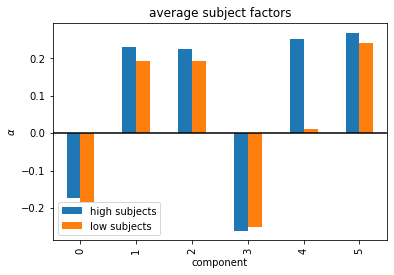

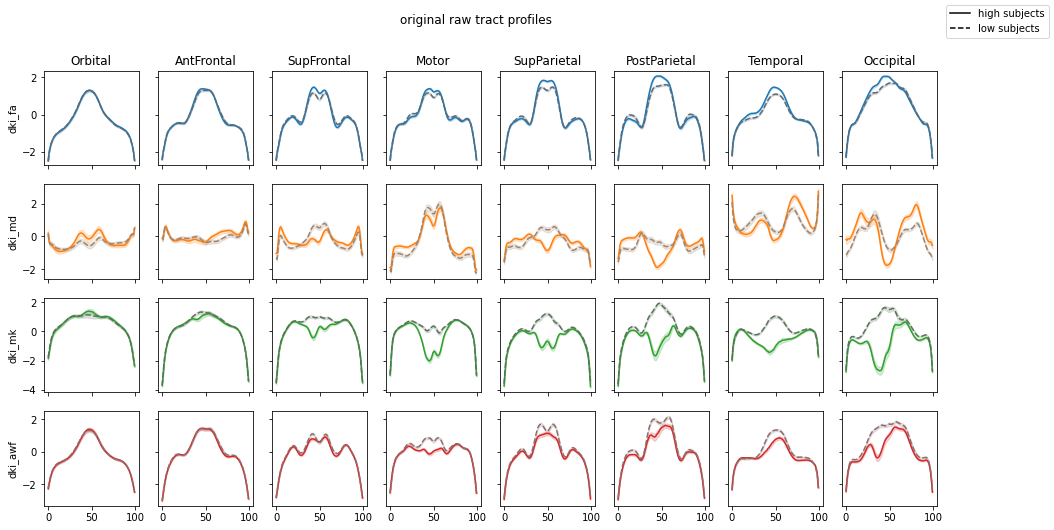

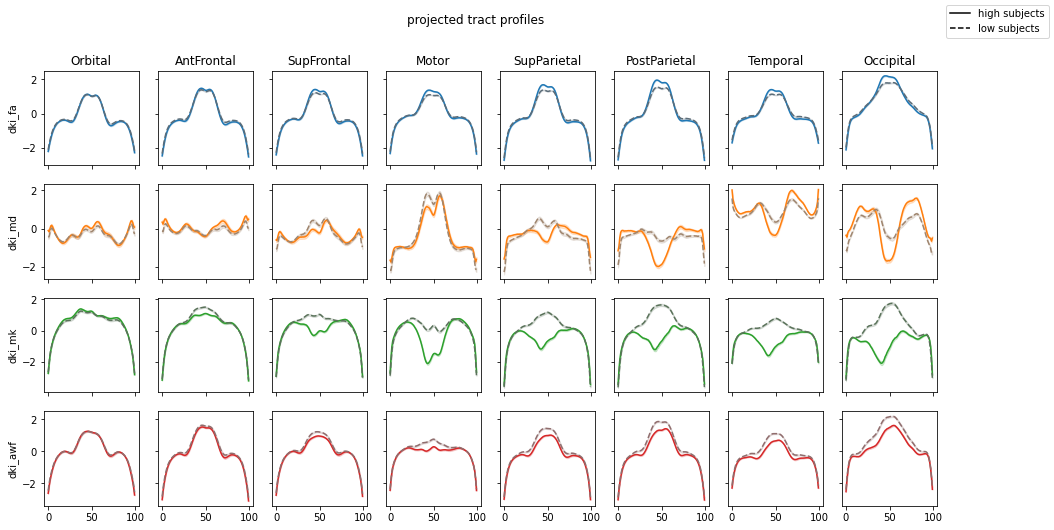

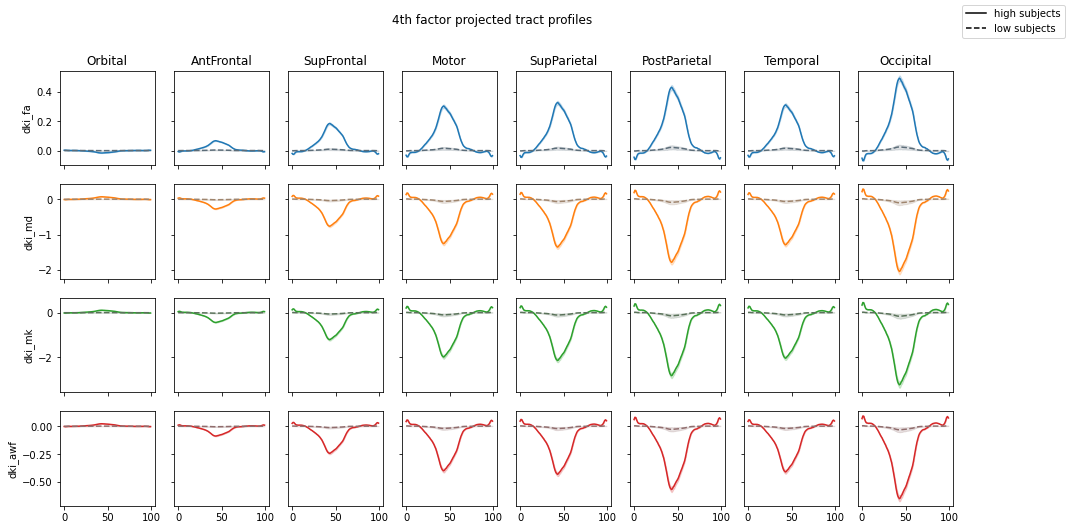

In [433]:
sample_high_low(normalized_masked_ensemble, n_components=6, n_subjects=100)

**Different patterns in subject factors (particularly factor 4) and different tract profiles**

- Review factor 4 in plots above